This exercise consists in analyzing a dataset containg timing information from a series of Time-to-Digital-Converters (TDC) implemented in a pair of FPGAs. Each measurement (i.e. each row of the input file) consists of a flag that specifies the type of message ('HEAD', which in this case is always 1), two addresses of the TDC providing the signal ('FPGA' and 'TDC_CHANNEL'), and the timing information ('ORBIT_CNT', 'BX_COUNTER', and 'TDC_MEAS'). Each TDC count corresponds to 25/30 ns, whereas a unit of BX_COUNTER corresponds to 25 ns, and the ORBIT_CNT is increased every 'x' BX_COUNTER. This allows to store the time in a similar way to hours, minutes and seconds.

In [ ]:
# If haven't downloaded it yet, please get the data file with wget
#!wget https://www.dropbox.com/s/xvjzaxzz3ysphme/data_000637.txt -P ./data/

1\. Create a Pandas DataFrame reading N rows of the `data/data_000637.txt` dataset. Choose N to be smaller than or equal to the maximum number of rows and larger that 10k (check the documentation).

In [1]:
import pandas as pd
import numpy as np

file_name = "../data/data_000637.txt"
data = pd.read_csv(file_name, nrows=11000)
data

HEAD  FPGA  TDC_CHANNEL   ORBIT_CNT  BX_COUNTER  TDC_MEAS
0         1     0          123  3869200167        2374        26
1         1     0          124  3869200167        2374        27
2         1     0           63  3869200167        2553        28
3         1     0           64  3869200167        2558        19
4         1     0           64  3869200167        2760        25
...     ...   ...          ...         ...         ...       ...
10995     1     0          139  3869200277         204         0
10996     1     0           61  3869200277         202        20
10997     1     0           63  3869200277         204         1
10998     1     0           59  3869200277         283        29
10999     1     0           63  3869200277         281        24

[11000 rows x 6 columns]

2\. Estimate the number of BX in a ORBIT (the value 'x').

In [2]:
file_name = "../data/data_000637.txt"
data = pd.read_csv(file_name)
x = np.max(data['BX_COUNTER']) + 1

print(x, "BX in a ORBIT")

3564 BX in a ORBIT


3\. Find out the duration of the data taking in hours, minutes and seconds. You can either make an estimate based on the fraction of the measurements (rows) you read, or perform this check precisely by reading the whole dataset.

In [3]:
row = data.iloc[0]

totalns = row['TDC_MEAS'] * 25 / 30 + row['BX_COUNTER'] * 25 + row['ORBIT_CNT'] * x * 25
print(pd.to_timedelta(totalns))

3 days 23:45:45.734939071


4\. Create a new column with the absolute time in ns (as a combination of the other three columns with timing information) since the beginning of the data acquisition.

In [4]:
data['TIMENS'] = data['TDC_MEAS'] * 25 / 30 + data['BX_COUNTER'] * 25 + data['ORBIT_CNT'] * x * 25 - totalns
data

HEAD  FPGA  TDC_CHANNEL   ORBIT_CNT  BX_COUNTER  TDC_MEAS  \
0           1     0          123  3869200167        2374        26   
1           1     0          124  3869200167        2374        27   
2           1     0           63  3869200167        2553        28   
3           1     0           64  3869200167        2558        19   
4           1     0           64  3869200167        2760        25   
...       ...   ...          ...         ...         ...       ...   
1310715     1     0           62  3869211171         762        14   
1310716     1     1            4  3869211171         763        11   
1310717     1     0           64  3869211171         764         0   
1310718     1     0          139  3869211171         769         0   
1310719     1     0           61  3869211171         762        18   

               TIMENS  
0        0.000000e+00  
1        8.125000e-01  
2        4.476625e+03  
3        4.594125e+03  
4        9.649125e+03  
...               ...  
1310715  9.804161e+08  
1310716  9.804161e+08  
1310717  9.804161e+08  
1310718  9.804163e+08  
1310719  9.804161e+08  

[1310720 rows x 7 columns]

5\. Use the `.groupby()` method to find out the noisy channels, i.e. the TDC channels with most counts (print to screen the top 3 and the corresponding counts)

In [5]:
print(data.groupby('TDC_CHANNEL').size().sort_values(ascending=False).head(3))

TDC_CHANNEL
139    108059
64      66020
63      64642
dtype: int64


6. Count the number of non-empty orbits (i.e. the number of orbits with at least one hit). Count also the number of unique orbits with at least one measurement from TDC_CHANNEL=139.

In [6]:
count_data = data.groupby('ORBIT_CNT').size().reset_index(name='counts')
print(count_data)
print("Number of non-empty orbits",len(count_data))

        ORBIT_CNT  counts
0      3869200167      43
1      3869200168      85
2      3869200169     127
3      3869200170      98
4      3869200171     109
...           ...     ...
10996  3869211167     208
10997  3869211168     109
10998  3869211169     191
10999  3869211170     137
11000  3869211171      22

[11001 rows x 2 columns]
Number of non-empty orbits 11001


In [7]:
new_data = data.groupby(['ORBIT_CNT','TDC_CHANNEL']).size().sort_values(ascending=False).reset_index(name='count')
print(new_data)
new_data['TDC_CHANNEL'] = new_data['TDC_CHANNEL'].mask(new_data['TDC_CHANNEL'].ne(139))
print(new_data)
print("Number of unique orbits", new_data.groupby(['TDC_CHANNEL']).size())

         ORBIT_CNT  TDC_CHANNEL  count
0       3869209765          139     26
1       3869208086          139     26
2       3869207118          139     25
3       3869210426          139     25
4       3869207714          139     25
...            ...          ...    ...
563079  3869206506           71      1
563080  3869206506           76      1
563081  3869206506           80      1
563082  3869206506           83      1
563083  3869200167            5      1

[563084 rows x 3 columns]
         ORBIT_CNT  TDC_CHANNEL  count
0       3869209765        139.0     26
1       3869208086        139.0     26
2       3869207118        139.0     25
3       3869210426        139.0     25
4       3869207714        139.0     25
...            ...          ...    ...
563079  3869206506          NaN      1
563080  3869206506          NaN      1
563081  3869206506          NaN      1
563082  3869206506          NaN      1
563083  3869200167          NaN      1

[563084 rows x 3 columns]
Number of 

7\. **Optional:** Make two occupancy plots (one for each FPGA), i.e. plot the number of counts per TDC channel

     TDC_CHANNEL  counts
0              1   29653
1              2   34271
2              3   23463
3              4   28755
4              5   16435
..           ...     ...
128          129      37
129          130      71
130          137      68
131          138      70
132          139  108059

[133 rows x 2 columns]


<AxesSubplot:xlabel='TDC_CHANNEL'>

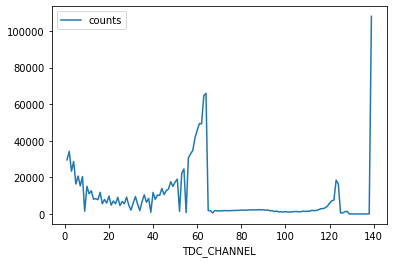

In [8]:
count_data = data.groupby('TDC_CHANNEL').size().reset_index(name='counts')
print(count_data)

count_data.plot(x='TDC_CHANNEL',y='counts')